# Producing weights for likelihood grid calculation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import pickle
import gc
from copy import deepcopy

from exp_analysis_class import full_likelihood
from dark_nus_utils import load_datasets
from const import alphaQED
from analyses_dict import analyses
from parameters_dict import *
from dark_nus_utils import store_events_weights, retrieve_events_weights

In [3]:
D_or_M = 'dirac'
hierarchy = 'heavy'

In [4]:
# my_exp_analyses = load_datasets(hierarchies=['heavy', 'light'],
#                                   D_or_Ms=D_or_M,
#                                   fluxes=['FHC', 'RHC'],
#                                 timeit=True, 
#                                 direct_load_objects=False,
#                                 load_grid=False,
#                                 dump=True,
#                                 nentries=1000000)

In [5]:
my_exp_analyses = load_datasets(
                                hierarchies=hierarchy, 
                                D_or_Ms=D_or_M, 
                                fluxes=['FHC', 'RHC'],
                                timeit=True, 
                                direct_load_objects=True,
                                load_grid=False,
                                dump=False,
                                nentries=1000000)

heavy dirac FHC
Wall time: 0.608635663986206 s, CPU time: 0.5961472859999999
heavy dirac RHC
Wall time: 0.5844032764434814 s, CPU time: 0.573378188


## Produce event weights on a grid

In [6]:
for case_name, case in likelihood_calculation_pars.items():
    if hierarchy in case_name:
        name = case['name']
        if name != 'mz_epsilon':
            continue
        hierarchy = case['hierarchy']
        analysis_name = case['analysis_name']
        pars = case['pars']
        additional_vars = case['additional_vars']
        for nu_mode in ['FHC', 'RHC']:
        # for nu_mode in ['RHC']:
            print(name, analysis_name, nu_mode)
            out = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_expectation(
                                                                my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base, 
                                                                **pars,
                                                                ntarget_per_material=None, 
                                                                pot=None,
                                                                selection_query=analyses[analysis_name][nu_mode]['selection'],
                                                                efficiency_factor=None,
                                                                no_pot_efficiency=True)
            store_events_weights(expectation_output=out, 
                                 analysis=analyses[analysis_name][nu_mode],
                                 pars=pars,
                                 name=f'{hierarchy}_{name}',
                                 analysis_name=analysis_name,
                                 nu_mode=nu_mode,
                                 additional_vars=additional_vars)
            del out
            gc.collect()

mz_epsilon tpc FHC
mz_epsilon tpc RHC


# Produce event weights on an arbitrary set of point

## $M_{Z^\prime}$ vs $\varepsilon$

In [6]:
likelihood_calculation_pars['heavy_mz_epsilon']['pars']

{'m4': 0.1,
 'mz': array([ 0.13      ,  0.16338399,  0.20534098,  0.25807252,  0.32434552,
         0.40763742,  0.51231868,  0.64388206,  0.80923092,  1.01704134,
         1.27821746,  1.60646358,  2.01900328,  2.53748313,  3.18910856,
         4.00807134,  5.03734368,  6.33093306,  7.95671607, 10.        ]),
 'alpha_dark': 0.4,
 'epsilon': array([1.00000000e-05, 1.46779927e-05, 2.15443469e-05, 3.16227766e-05,
        4.64158883e-05, 6.81292069e-05, 1.00000000e-04, 1.46779927e-04,
        2.15443469e-04, 3.16227766e-04, 4.64158883e-04, 6.81292069e-04,
        1.00000000e-03, 1.46779927e-03, 2.15443469e-03, 3.16227766e-03,
        4.64158883e-03, 6.81292069e-03, 1.00000000e-02, 1.46779927e-02,
        2.15443469e-02, 3.16227766e-02, 4.64158883e-02, 6.81292069e-02,
        1.00000000e-01]),
 'Umu4_2': 2.2e-07,
 'Ud4_2': 1}

In [7]:
xy_grid_base = np.exp(np.mgrid[np.log(likelihood_calculation_pars['heavy_mz_epsilon']['pars']['mz'][0]):np.log(likelihood_calculation_pars['heavy_mz_epsilon']['pars']['mz'][-1]):11j,
         np.log(likelihood_calculation_pars['heavy_mz_epsilon']['pars']['epsilon'][0]):np.log(likelihood_calculation_pars['heavy_mz_epsilon']['pars']['epsilon'][-1]):10j])
xy_grid_base = xy_grid_base.reshape(2, -1)

In [8]:
xy_grid_fine = np.exp(np.mgrid[np.log(likelihood_calculation_pars['heavy_mz_epsilon']['pars']['mz'][0]):np.log(likelihood_calculation_pars['heavy_mz_epsilon']['pars']['mz'][-1]):32j,
         np.log(likelihood_calculation_pars['heavy_mz_epsilon']['pars']['epsilon'][0]):np.log(likelihood_calculation_pars['heavy_mz_epsilon']['pars']['epsilon'][-1]):29j])
xy_grid_fine = xy_grid_fine.reshape(2, -1)

In [9]:
def in_boundary(point_x, point_y, a, b):
    return (np.log10(point_y) - a[1]) <= (np.log10(point_x)-a[0])*(b[1]-a[1])/(b[0]-a[0])

In [10]:
in_boundary1 = in_boundary(xy_grid_fine[0], xy_grid_fine[1], a=np.log10([0.13, 3e-3]), b=np.log10([0.8, 1e-1]))
in_boundary2 = in_boundary(xy_grid_fine[0], xy_grid_fine[1], a=np.log10([0.13, 1e-5]), b=np.log10([10, 1e-1]))
mask = in_boundary1 & ~(in_boundary2)
xy_grid_fine = xy_grid_fine[:, mask]

In [11]:
xy_grid = np.concatenate((xy_grid_fine, xy_grid_base), axis=1)

[]

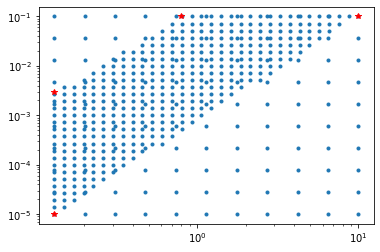

In [12]:
plt.plot(xy_grid[0], xy_grid[1], '.')
plt.plot(0.13, 3e-3, 'r*')
plt.plot(0.8, 1e-1, 'r*')
plt.plot(0.13, 1e-5, 'r*')
plt.plot(10, 1e-1, 'r*')
plt.loglog()

In [13]:
xy_grid.shape

(2, 492)

In [14]:
for case_name, case in likelihood_calculation_pars.items():
    if hierarchy in case_name:
        name = case['name']
        if name != 'mz_epsilon':
            continue
        hierarchy = case['hierarchy']
        analysis_name = case['analysis_name']
        pars = deepcopy(case['pars'])
        additional_vars = case['additional_vars']
        for nu_mode in ['FHC', 'RHC']:
            print(nu_mode)
            aux_weights = []
            aux_n_kde = []
            for i, (x, y) in enumerate(xy_grid.T):
                if i%100 == 0:
                    print(i)
                pars['mz'] = x
                pars['epsilon'] = y
                out = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_expectation(
                                                                        my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base, 
                                                                        **pars,
                                                                        ntarget_per_material=None, 
                                                                        pot=None,
                                                                        selection_query=analyses[analysis_name][nu_mode]['selection'],
                                                                        efficiency_factor=None,
                                                                        no_pot_efficiency=True)
                if i == 0:
                    aux_df = deepcopy(out[0])
                    pars['mz'] = xy_grid[0]
                    pars['epsilon'] = xy_grid[1]
                    aux_pars = deepcopy(pars)
                aux_weights.append(out[1])
                aux_n_kde.append(out[2])
                del out
                gc.collect()
            aux_weights = np.stack(aux_weights, axis=1)
            aux_n_kde = np.stack(aux_n_kde)
            store_events_weights(expectation_output=(aux_df, aux_weights, aux_n_kde),
                                 analysis=analyses[analysis_name][nu_mode],
                                 pars=aux_pars,
                                 name=f'{hierarchy}_{name}',
                                 analysis_name=analysis_name,
                                 nu_mode=nu_mode,
                                 additional_vars=additional_vars)

FHC
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
RHC
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
